In [140]:
import pickle
import matplotlib.pyplot as plt
import glob
from utils import helper_funcs
import numpy as np
import networkx as nx

# Data loading

In [64]:
def load(dirname, N=1):
    '''
    Load the best-of-N simulation results for each benchmark graph in the given directory
    '''
    all_graphs = glob.glob(dirname + 'G*')
    all_pickles = []
    for benchmark_graph in all_graphs:
        pickle_fns = glob.glob(benchmark_graph + '/*pickle')
        temp_list = []
        for pickle_fn in pickle_fns:
            with open(pickle_fn, 'rb') as pklfile:
                cur_pickle = pickle.load(pklfile)
            temp_list.append(cur_pickle)
        
        # Sort the repetitions
        sorted_reps = sorted(temp_list, key=lambda p: helper_funcs.hamming_weight(p[1][-1][0]), reverse=True)

        # Include the top N reps in the final average
        for i in range(N):
            all_pickles.append((sorted_reps[i], benchmark_graph))
            
    return all_pickles

def get_classical_results(kind, graphtype):
    if kind == 'bh':
        result_dir = 'boppana-halldorsson'
    elif kind == 'dc':
        result_dir = 'classical_divide_and_conquer'
    else:
        raise ValueError(f'Unknown classical algorithm: {kind}')
    
    all_graphs = glob.glob(f'benchmark_results/{result_dir}/{graphtype}_graphs/G*')
    approx_ratios = []
    for graph_dir in all_graphs:
        all_reps = glob.glob(graph_dir + '/*.txt')
        best_mis = 0
        for rep in all_reps:
            with open(rep, 'r') as repfn:
                for l, line in enumerate(repfn):
                    if l == 1:
                        if kind == 'bh':
                            cur_mis = int(line.split()[-1])
                        elif kind == 'dc':
                            cur_mis = int(line.split()[-1].strip(']'))
            if cur_mis > best_mis:
                best_mis = cur_mis
        
        # Get the optimal mis for this graph
        graphnum = graph_dir.split('/')[-1]
        with open(f'benchmark_graphs/brute_force_outputs/{graphtype}_graphs/{graphnum}_brute_force.out', 'r') as bf_file:
            for l, line in enumerate(bf_file):
                if l == 1:
                    optimal_mis = int(line.split()[-1])
        approx_ratios.append(best_mis / optimal_mis)
    return np.mean(approx_ratios)

In [141]:
benchmarks = ['N26_com2_pin20_pout2_2frags_0cuts_5000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_40000shots/',
                  'N26_com2_pin20_pout2_2frags_2cuts_60000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_90000shots/',]
N26_com2_data = [(benchmark, load('benchmark_results/MICRO_results/COBYLA/' + benchmark, N=1)) for benchmark in benchmarks]

In [142]:
benchmarks = ['N18_com2_pin20_pout2_2frags_0cuts_5000shots/', 'N18_com2_pin20_pout2_2frags_1cuts_40000shots/',
                  'N18_com2_pin20_pout2_2frags_2cuts_60000shots/', 'N18_com2_pin20_pout2_2frags_3cuts_90000shots/',]
N18_com2_data = [(benchmark, load('benchmark_results/MICRO_results/COBYLA/' + benchmark, N=1)) for benchmark in benchmarks]

In [143]:
benchmarks = ['N26_d3_2frags_0cuts_5000shots/', 'N26_d3_2frags_1cuts_40000shots/',
                  'N26_d3_2frags_2cuts_60000shots/', 'N26_d3_2frags_3cuts_90000shots/',]
N26_d3_data = [(benchmark, load('benchmark_results/MICRO_results/COBYLA/' + benchmark, N=1)) for benchmark in benchmarks]

In [144]:
benchmarks = ['N18_d3_2frags_0cuts_5000shots/', 'N18_d3_2frags_1cuts_40000shots/',
                  'N18_d3_2frags_2cuts_60000shots/', 'N18_d3_2frags_3cuts_90000shots/',]
N18_d3_data = [(benchmark, load('benchmark_results/MICRO_results/COBYLA/' + benchmark, N=1)) for benchmark in benchmarks]

# Fragment shots, cut ratio, number of partial mixers

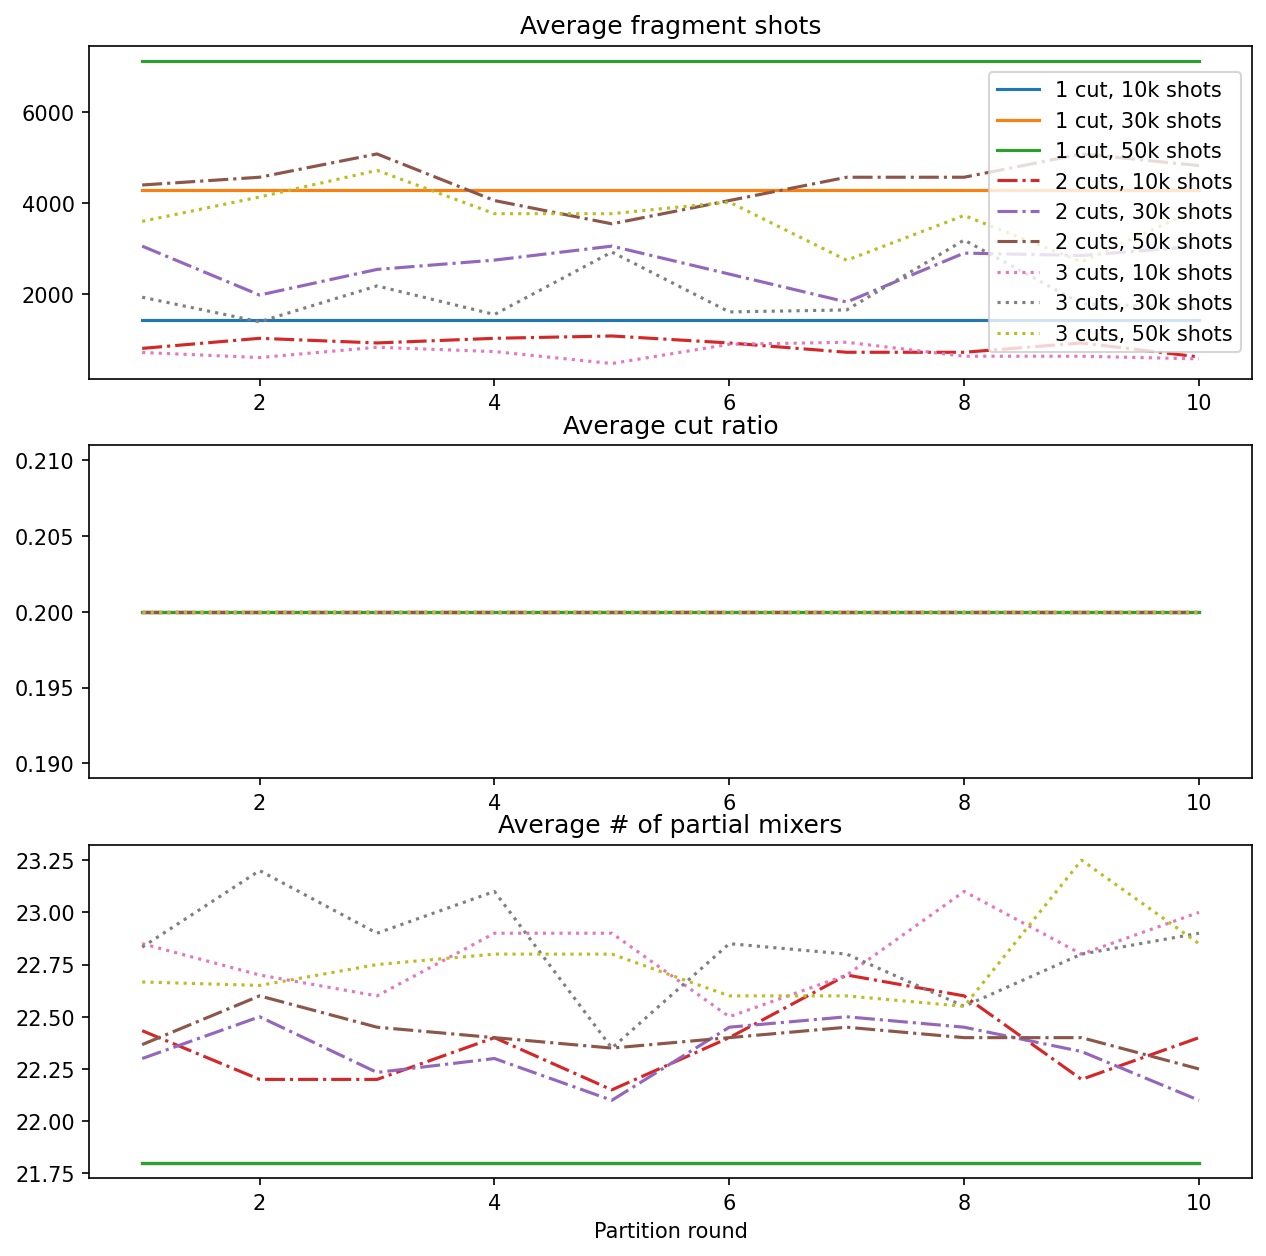

In [3]:
# Average number of fragment shots, cut ratio, number of partial mixers over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=3, ncols=1, figsize=[10,10])

benchmarks = ['N26_com2_pin20_pout2_2frags_1cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_50000shots/',
              'N26_com2_pin20_pout2_2frags_2cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_50000shots/',
              'N26_com2_pin20_pout2_2frags_3cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_50000shots/',]
labels = ['1 cut, 10k shots', '1 cut, 30k shots', '1 cut, 50k shots',
          '2 cuts, 10k shots', '2 cuts, 30k shots', '2 cuts, 50k shots',
          '3 cuts, 10k shots', '3 cuts, 30k shots', '3 cuts, 50k shots',]
linestyles = ['-', '-', '-',
              '-.', '-.', '-.',
              ':', ':', ':',
              '--', '--', '--',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark)
    
    # How many fragment shots, cut ratio, number of partial mixers?
    frag_shots_results = []
    cut_ratio_results = []
    num_partialmixers_results = []
    for (graph, sim_result), _ in data:
        temp_fs, temp_cr, temp_pm = [], [], []
        for i, partition_round in enumerate(sim_result):
            cut_nodes = partition_round[-2]
            temp_cr.append(len(cut_nodes) / graph.number_of_nodes())
            
            history = partition_round[-1][0]
            frag_shots = []
            num_parmix = []
            for inner_round in history:
                frag_shots.append(inner_round['frag_shots'])
                num_parmix.append(inner_round['num_params'] - 1)
            
            temp_fs.append(np.mean(frag_shots))
            temp_pm.append(np.mean(num_parmix))
        
        frag_shots_results.append(temp_fs)
        cut_ratio_results.append(temp_cr)
        num_partialmixers_results.append(temp_pm)
    
    avg_fs = np.mean(frag_shots_results, axis=0)
    avg_cr = np.mean(cut_ratio_results, axis=0)
    avg_pm = np.mean(num_partialmixers_results, axis=0)
    
    xvals = np.arange(1,len(avg_fs)+1)
    
    ax[0].plot(xvals, avg_fs, label=labels[idx], ls=linestyles[idx])
    ax[1].plot(xvals, avg_cr, label=labels[idx], ls=linestyles[idx])
    ax[2].plot(xvals, avg_pm, label=labels[idx], ls=linestyles[idx])
    
ax[0].set_title('Average fragment shots')
ax[1].set_title('Average cut ratio')
ax[2].set_title('Average # of partial mixers')
ax[2].set_xlabel('Partition round')
ax[0].legend()
plt.show()
plt.close()

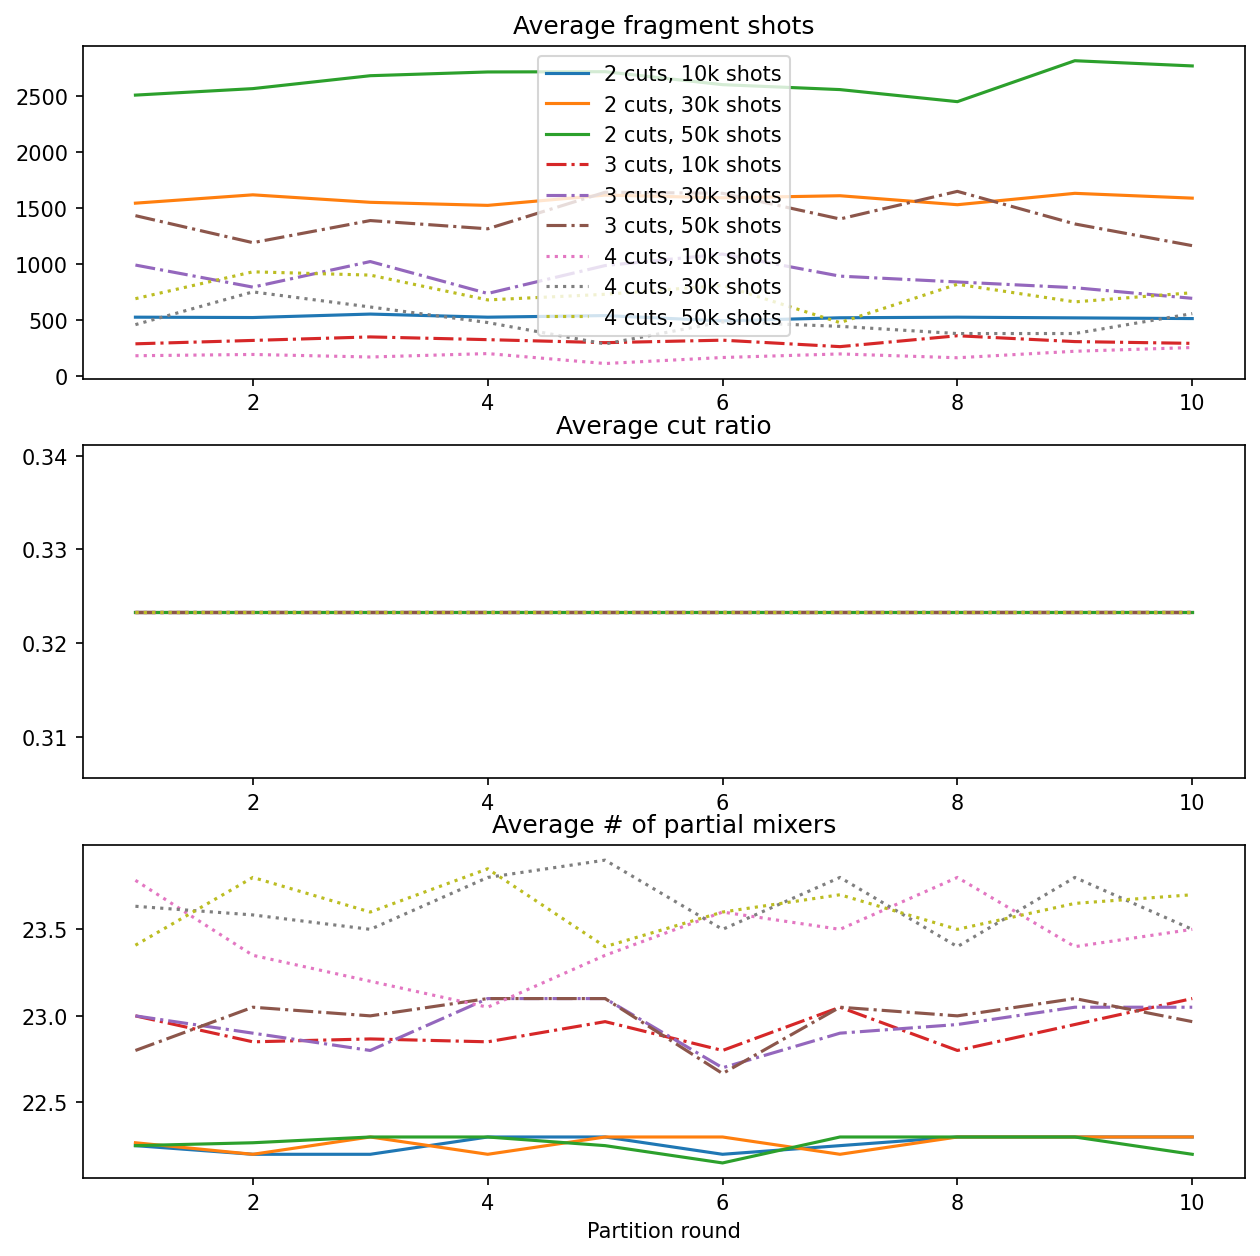

In [63]:
# Average number of fragment shots, cut ratio, number of partial mixers over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=3, ncols=1, figsize=[10,10])

benchmarks = ['N30_com3_pin20_pout2_3frags_2cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_50000shots/',
              'N30_com3_pin20_pout2_3frags_3cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_50000shots/',
              'N30_com3_pin20_pout2_3frags_4cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_50000shots/',]
labels = ['2 cuts, 10k shots', '2 cuts, 30k shots', '2 cuts, 50k shots',
          '3 cuts, 10k shots', '3 cuts, 30k shots', '3 cuts, 50k shots',
          '4 cuts, 10k shots', '4 cuts, 30k shots', '4 cuts, 50k shots',]
linestyles = ['-', '-', '-',
              '-.', '-.', '-.',
              ':', ':', ':',
              '--', '--', '--',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark, N=1)
    
    # How many fragment shots, cut ratio, number of partial mixers?
    frag_shots_results = []
    cut_ratio_results = []
    num_partialmixers_results = []
    for (graph, sim_result), _ in data:
        temp_fs, temp_cr, temp_pm = [], [], []
        for i, partition_round in enumerate(sim_result):
            cut_nodes = partition_round[-2]
            temp_cr.append(len(cut_nodes) / graph.number_of_nodes())
            
            history = partition_round[-1][0]
            frag_shots = []
            num_parmix = []
            for inner_round in history:
                frag_shots.append(inner_round['frag_shots'])
                num_parmix.append(inner_round['num_params'] - 1)
            
            temp_fs.append(np.mean(frag_shots))
            temp_pm.append(np.mean(num_parmix))
        
        frag_shots_results.append(temp_fs)
        cut_ratio_results.append(temp_cr)
        num_partialmixers_results.append(temp_pm)
    
    avg_fs = np.mean(frag_shots_results, axis=0)
    avg_cr = np.mean(cut_ratio_results, axis=0)
    avg_pm = np.mean(num_partialmixers_results, axis=0)
    
    xvals = np.arange(1,len(avg_fs)+1)
    
    ax[0].plot(xvals, avg_fs, label=labels[idx], ls=linestyles[idx])
    ax[1].plot(xvals, avg_cr, label=labels[idx], ls=linestyles[idx])
    ax[2].plot(xvals, avg_pm, label=labels[idx], ls=linestyles[idx])
    
ax[0].legend()
ax[0].set_title('Average fragment shots')
ax[1].set_title('Average cut ratio')
ax[2].set_title('Average # of partial mixers')
ax[2].set_xlabel('Partition round')
plt.show()
plt.close()

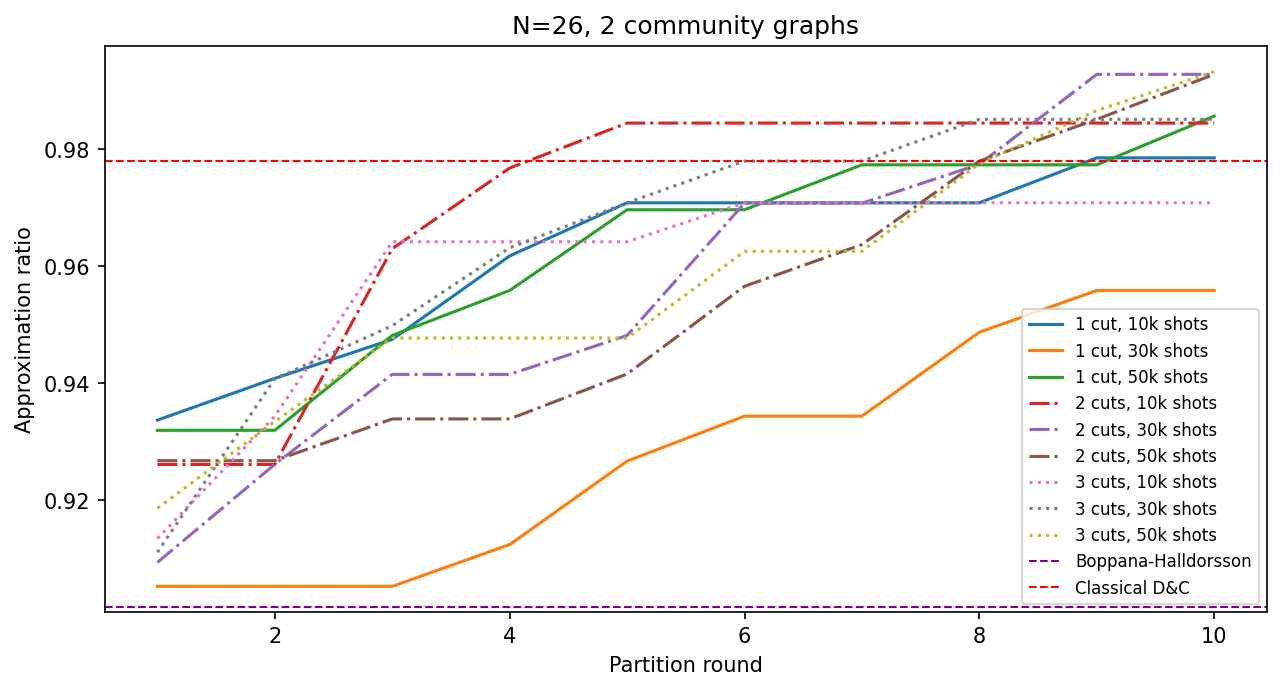

In [62]:
# Average approximation ratio over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=1, ncols=1, figsize=[10,5])

benchmarks = ['N26_com2_pin20_pout2_2frags_1cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_50000shots/',
              'N26_com2_pin20_pout2_2frags_2cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_50000shots/',
              'N26_com2_pin20_pout2_2frags_3cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_50000shots/',]
labels = ['1 cut, 10k shots', '1 cut, 30k shots', '1 cut, 50k shots',
          '2 cuts, 10k shots', '2 cuts, 30k shots', '2 cuts, 50k shots',
          '3 cuts, 10k shots', '3 cuts, 30k shots', '3 cuts, 50k shots',]
linestyles = ['-', '-', '-',
              '-.', '-.', '-.',
              ':', ':', ':',
              '--', '--', '--',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark)
    
    approx_ratio_results = []
    for (graph, sim_result), benchmark_graph in data:
        # Get the optimal mis for this graph
        parts = benchmark_graph.split('/')
        brute_force_dir = parts[-2].split('frags')[0][:-1] + 'graphs/' + parts[-1] + '_brute_force.out'
        with open('benchmark_graphs/brute_force_outputs/' + brute_force_dir, 'r') as bf_file:
            for l, line in enumerate(bf_file):
                if l == 1:
                    optimal_mis = int(line.split()[-1])
        
        # Average of the QDC results
        temp_ar = []
        for i, partition_round in enumerate(sim_result):
            best_indset = partition_round[0]
            temp_ar.append(helper_funcs.hamming_weight(best_indset) / optimal_mis)
        
        approx_ratio_results.append(temp_ar)
    
    avg_ar = np.mean(approx_ratio_results, axis=0)
    
    xvals = np.arange(1,len(avg_ar)+1)
    
    ax.plot(xvals, avg_ar, label=labels[idx], ls=linestyles[idx])

# Plot the classical comparison
ax.axhline(get_classical_results('bh', 'N26_com2_pin20_pout2'), label='Boppana-Halldorsson', ls='--', lw=1, c='purple')
ax.axhline(get_classical_results('dc', 'N26_com2_pin20_pout2'), label='Classical D&C', ls='--', lw=1, c='r')
    
ax.legend(fontsize=8)
ax.set_title('N=26, 2 community graphs')
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Partition round')
plt.show()
plt.close()

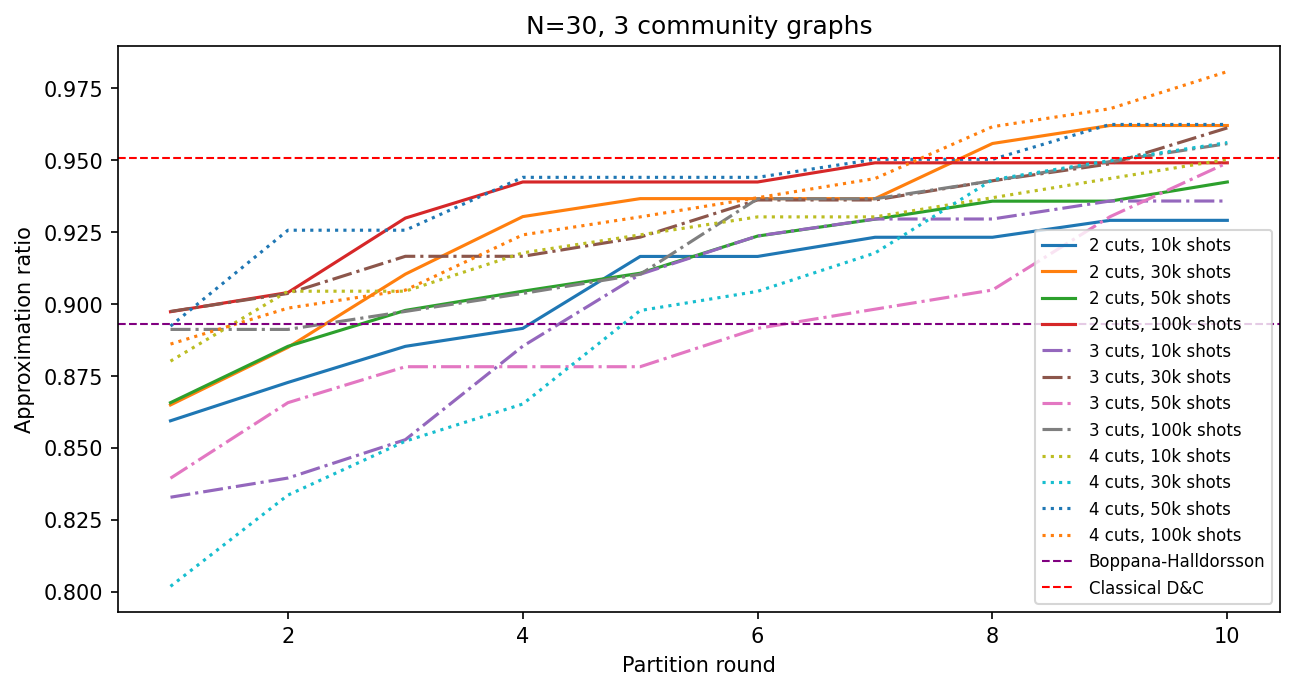

In [61]:
# Average approximation ratio over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=1, ncols=1, figsize=[10,5])

benchmarks = ['N30_com3_pin20_pout2_3frags_2cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_50000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_100000shots/',
              'N30_com3_pin20_pout2_3frags_3cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_50000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_100000shots/',
              'N30_com3_pin20_pout2_3frags_4cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_50000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_100000shots/',]
labels = ['2 cuts, 10k shots', '2 cuts, 30k shots', '2 cuts, 50k shots', '2 cuts, 100k shots',
          '3 cuts, 10k shots', '3 cuts, 30k shots', '3 cuts, 50k shots', '3 cuts, 100k shots',
          '4 cuts, 10k shots', '4 cuts, 30k shots', '4 cuts, 50k shots', '4 cuts, 100k shots',]
linestyles = ['-', '-', '-', '-',
              '-.', '-.', '-.', '-.',
              ':', ':', ':', ':',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark, N=1)
    
    approx_ratio_results = []
    for (graph, sim_result), benchmark_graph in data:
        # Get the optimal mis for this graph
        parts = benchmark_graph.split('/')
        brute_force_dir = parts[-2].split('frags')[0][:-1] + 'graphs/' + parts[-1] + '_brute_force.out'
        with open('benchmark_graphs/brute_force_outputs/' + brute_force_dir, 'r') as bf_file:
            for l, line in enumerate(bf_file):
                if l == 1:
                    optimal_mis = int(line.split()[-1])
        
        # Average of the QDC results
        temp_ar = []
        for i, partition_round in enumerate(sim_result):
            best_indset = partition_round[0]
            temp_ar.append(helper_funcs.hamming_weight(best_indset) / optimal_mis)
        
        approx_ratio_results.append(temp_ar)
    
    avg_ar = np.mean(approx_ratio_results, axis=0)
    
    xvals = np.arange(1,len(avg_ar)+1)
    
    ax.plot(xvals, avg_ar, label=labels[idx], ls=linestyles[idx])
    
# Plot the classical comparison
ax.axhline(get_classical_results('bh', 'N30_com3_pin20_pout2'), label='Boppana-Halldorsson', ls='--', lw=1, c='purple')
ax.axhline(get_classical_results('dc', 'N30_com3_pin20_pout2'), label='Classical D&C', ls='--', lw=1, c='r')
    

ax.legend(fontsize=8)
ax.set_title('N=30, 3 community graphs')
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Partition round')
plt.show()
plt.close()

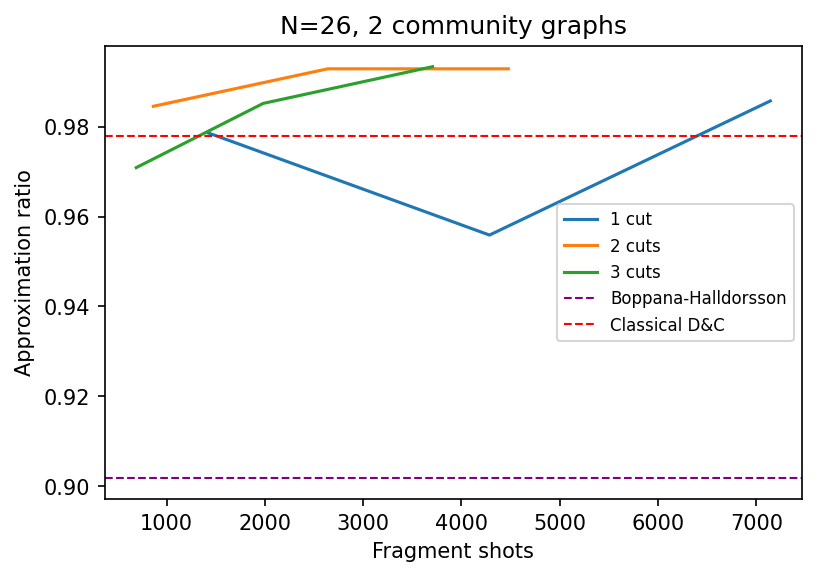

In [59]:
# Final approximation ratio dependence on fragment shots
# Average number of fragment shots, cut ratio, number of partial mixers over partition rounds
fig, ax = plt.subplots(dpi=150)

benchmarks = [['N26_com2_pin20_pout2_2frags_1cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_50000shots/'],
              ['N26_com2_pin20_pout2_2frags_2cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_50000shots/'],
              ['N26_com2_pin20_pout2_2frags_3cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_50000shots/'],]
labels = ['1 cut', '2 cuts', '3 cuts',]

for idx, same_cut_benchmarks in enumerate(benchmarks):
    frag_shots_results = []
    approx_ratio_results = []
    for benchmark in same_cut_benchmarks:
        data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark, N=1)

        all_graph_frag_shots = []
        all_graph_approx_ratio = []
        for (graph, sim_result), benchmark_graph in data:
            # Get the average number of fragment shots
            avg_partition_round_frag_shots = []
            for i, partition_round in enumerate(sim_result):
                history = partition_round[-1][0]
                inner_round_frag_shots = []
                for inner_round in history:
                    inner_round_frag_shots.append(inner_round['frag_shots'])
                avg_partition_round_frag_shots.append(np.mean(inner_round_frag_shots))
            all_graph_frag_shots.append(np.mean(avg_partition_round_frag_shots))

            # Get the optimal mis for this graph
            parts = benchmark_graph.split('/')
            brute_force_dir = parts[-2].split('frags')[0][:-1] + 'graphs/' + parts[-1] + '_brute_force.out'
            with open('benchmark_graphs/brute_force_outputs/' + brute_force_dir, 'r') as bf_file:
                for l, line in enumerate(bf_file):
                    if l == 1:
                        optimal_mis = int(line.split()[-1])

            # Get the final approximation ratio
            final_indset = sim_result[-1][0]
            all_graph_approx_ratio.append(helper_funcs.hamming_weight(final_indset) / optimal_mis)

        # Average over all graphs for this benchmark
        frag_shots_results.append(np.mean(all_graph_frag_shots))
        approx_ratio_results.append(np.mean(all_graph_approx_ratio))
    
    # Plot the results
    ax.plot(frag_shots_results, approx_ratio_results, label=labels[idx])
    
# Plot the classical comparison
ax.axhline(get_classical_results('bh', 'N26_com2_pin20_pout2'), label='Boppana-Halldorsson', ls='--', lw=1, c='purple')
ax.axhline(get_classical_results('dc', 'N26_com2_pin20_pout2'), label='Classical D&C', ls='--', lw=1, c='r')

ax.legend(fontsize=8)
ax.set_title('N=26, 2 community graphs')
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Fragment shots')
plt.show()
plt.close()

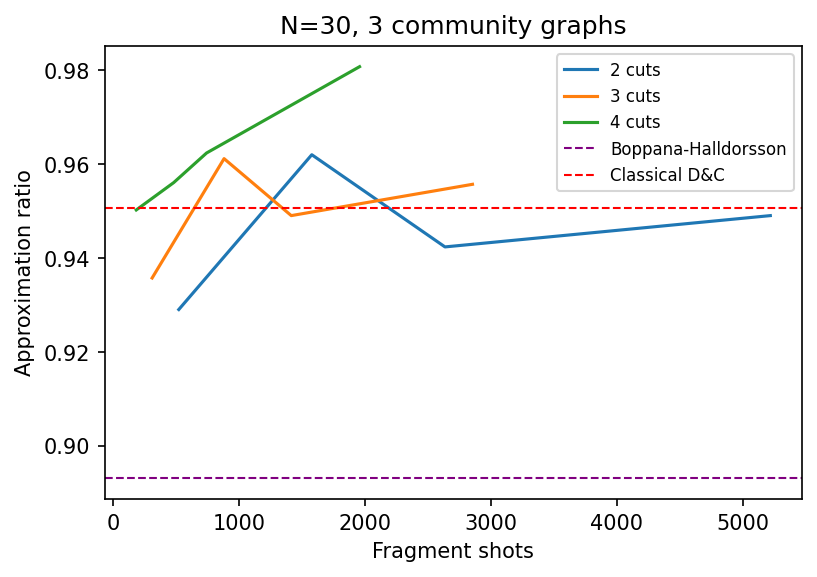

In [60]:
# Final approximation ratio dependence on fragment shots
# Average number of fragment shots, cut ratio, number of partial mixers over partition rounds
fig, ax = plt.subplots(dpi=150)

benchmarks = [['N30_com3_pin20_pout2_3frags_2cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_50000shots/', 'N30_com3_pin20_pout2_3frags_2cuts_100000shots/'],
              ['N30_com3_pin20_pout2_3frags_3cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_50000shots/', 'N30_com3_pin20_pout2_3frags_3cuts_100000shots/'],
              ['N30_com3_pin20_pout2_3frags_4cuts_10000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_30000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_50000shots/', 'N30_com3_pin20_pout2_3frags_4cuts_100000shots/'],]
labels = ['2 cuts', '3 cuts', '4 cuts',]

for idx, same_cut_benchmarks in enumerate(benchmarks):
    frag_shots_results = []
    approx_ratio_results = []
    for benchmark in same_cut_benchmarks:
        data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark, N=1)

        all_graph_frag_shots = []
        all_graph_approx_ratio = []
        for (graph, sim_result), benchmark_graph in data:
            # Get the average number of fragment shots
            avg_partition_round_frag_shots = []
            for i, partition_round in enumerate(sim_result):
                history = partition_round[-1][0]
                inner_round_frag_shots = []
                for inner_round in history:
                    inner_round_frag_shots.append(inner_round['frag_shots'])
                avg_partition_round_frag_shots.append(np.mean(inner_round_frag_shots))
            all_graph_frag_shots.append(np.mean(avg_partition_round_frag_shots))

            # Get the optimal mis for this graph
            parts = benchmark_graph.split('/')
            brute_force_dir = parts[-2].split('frags')[0][:-1] + 'graphs/' + parts[-1] + '_brute_force.out'
            with open('benchmark_graphs/brute_force_outputs/' + brute_force_dir, 'r') as bf_file:
                for l, line in enumerate(bf_file):
                    if l == 1:
                        optimal_mis = int(line.split()[-1])

            # Get the final approximation ratio
            final_indset = sim_result[-1][0]
            all_graph_approx_ratio.append(helper_funcs.hamming_weight(final_indset) / optimal_mis)

        # Average over all graphs for this benchmark
        frag_shots_results.append(np.mean(all_graph_frag_shots))
        approx_ratio_results.append(np.mean(all_graph_approx_ratio))
    
    # Plot the results
    ax.plot(frag_shots_results, approx_ratio_results, label=labels[idx])
    
# Plot the classical comparison
ax.axhline(get_classical_results('bh', 'N30_com3_pin20_pout2'), label='Boppana-Halldorsson', ls='--', lw=1, c='purple')
ax.axhline(get_classical_results('dc', 'N30_com3_pin20_pout2'), label='Classical D&C', ls='--', lw=1, c='r')

ax.legend(fontsize=8)
ax.set_title('N=30, 3 community graphs')
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Fragment shots')
plt.show()
plt.close()

# Number of function evaluations

N26_com2_pin20_pout2_2frags_1cuts_10000shots/
	 benchmark_results/ISCA_results/COBYLA/N26_com2_pin20_pout2_2frags_1cuts_10000shots/G6
		Partition round 1 inner round function evals: [224, 284, 234]
		Partition round 2 inner round function evals: [276]
		Partition round 3 inner round function evals: [293, 279]
		Partition round 4 inner round function evals: [276]
		Partition round 5 inner round function evals: [248]
		Partition round 6 inner round function evals: [270]
		Partition round 7 inner round function evals: [257]
		Partition round 8 inner round function evals: [268]
		Partition round 9 inner round function evals: [246]
		Partition round 10 inner round function evals: [319]
	 benchmark_results/ISCA_results/COBYLA/N26_com2_pin20_pout2_2frags_1cuts_10000shots/G1
		Partition round 1 inner round function evals: [314, 345, 331]
		Partition round 2 inner round function evals: [344]
		Partition round 3 inner round function evals: [325]
		Partition round 4 inner round function evals: [2

"\n    ax[0].plot(xvals, avg_fs, label=labels[idx], ls=linestyles[idx])\n    ax[1].plot(xvals, avg_cr, label=labels[idx], ls=linestyles[idx])\n    ax[2].plot(xvals, avg_pm, label=labels[idx], ls=linestyles[idx])\n    \nax[0].set_title('Average fragment shots')\nax[1].set_title('Average cut ratio')\nax[2].set_title('Average # of partial mixers')\nax[2].set_xlabel('Partition round')\nax[0].legend()\nplt.show()\nplt.close()\n"

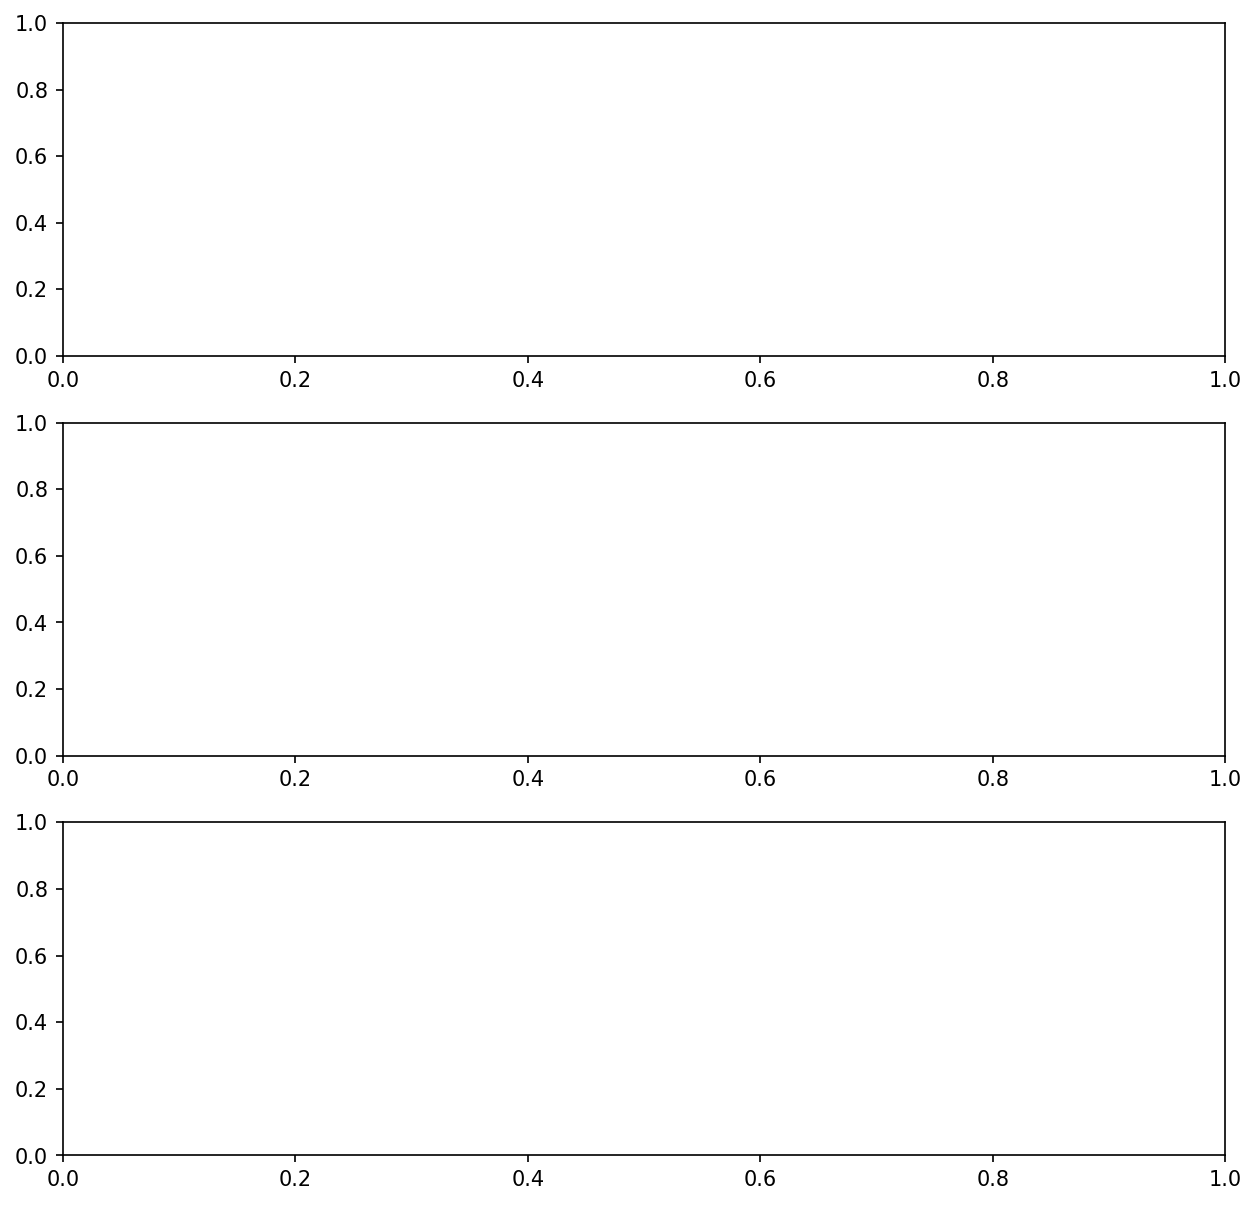

In [67]:
# Average number of fragment shots, cut ratio, number of partial mixers over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=3, ncols=1, figsize=[10,10])

benchmarks = ['N26_com2_pin20_pout2_2frags_1cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_1cuts_50000shots/',
              'N26_com2_pin20_pout2_2frags_2cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_2cuts_50000shots/',
              'N26_com2_pin20_pout2_2frags_3cuts_10000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_30000shots/', 'N26_com2_pin20_pout2_2frags_3cuts_50000shots/',]
labels = ['1 cut, 10k shots', '1 cut, 30k shots', '1 cut, 50k shots',
          '2 cuts, 10k shots', '2 cuts, 30k shots', '2 cuts, 50k shots',
          '3 cuts, 10k shots', '3 cuts, 30k shots', '3 cuts, 50k shots',]
linestyles = ['-', '-', '-',
              '-.', '-.', '-.',
              ':', ':', ':',
              '--', '--', '--',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark)
    
    print(benchmark)
    
    # How many fragment shots, cut ratio, number of partial mixers?
    frag_shots_results = []
    cut_ratio_results = []
    num_partialmixers_results = []
    for (graph, sim_result), benchmark_graph in data:
        print('\t', benchmark_graph)
        for i, partition_round in enumerate(sim_result):
            history = partition_round[-1][0]
            function_evals = []
            for inner_round in history:
                function_evals.append(inner_round['function_evals'])
            print(f'\t\tPartition round {i+1} inner round function evals: {function_evals}')
            
"""
    ax[0].plot(xvals, avg_fs, label=labels[idx], ls=linestyles[idx])
    ax[1].plot(xvals, avg_cr, label=labels[idx], ls=linestyles[idx])
    ax[2].plot(xvals, avg_pm, label=labels[idx], ls=linestyles[idx])
    
ax[0].set_title('Average fragment shots')
ax[1].set_title('Average cut ratio')
ax[2].set_title('Average # of partial mixers')
ax[2].set_xlabel('Partition round')
ax[0].legend()
plt.show()
plt.close()
"""

# Plotting subgraphs

In [127]:
def plot_subgraphs(rep_file):
    with open(rep_file, 'rb') as pklfile:
        data = pickle.load(pklfile)
        
    G = data[0]
    full_history = data[1]
    for i, partition_round in enumerate(full_history):
        partition = partition_round[4]
        cut_nodes = partition_round[5]
        print(i, partition, len(cut_nodes) / len(G.nodes))

    print(cut_nodes)
    colors = ['gold', 'skyblue', 'tab:orange', 'lightgreen']
    node_color = [None] * len(G.nodes)
    for i, subgraph in enumerate(partition):
        for node in subgraph:
            node_color[node] = colors[i]
    nx.draw_spring(G, with_labels=True, node_color=node_color)

0 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
1 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
2 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
3 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
4 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
5 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
6 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
7 [[0, 1, 16, 23, 24, 25, 26, 27, 

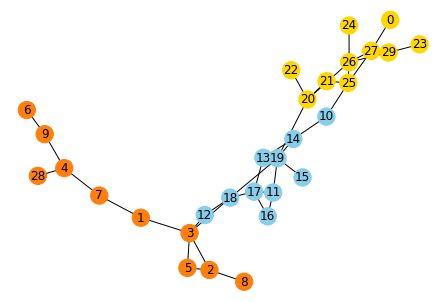

In [128]:
plot_subgraphs('benchmark_results/ISCA_results/COBYLA/N30_com3_pin20_pout2_3frags_2cuts_40000shots/G2/dqva_G2_2cuts_rep1.pickle')

# Average approximation ratios

In [67]:
def plot_approximation_ratios(data, title=None, savefig=None):
    # Average approximation ratio over partition rounds
    fig, ax = plt.subplots(dpi=150, nrows=1, ncols=1, figsize=[10,5])

    labels = ['0 cuts', '1 cut', '2 cuts', '3 cuts']

    for idx, (_, dat) in enumerate(data):
        approx_ratio_results = []
        for (graph, sim_result), benchmark_graph in dat:
            # Get the optimal mis for this graph
            parts = benchmark_graph.split('/')
            brute_force_dir = parts[-2].split('frags')[0][:-1] + 'graphs/' + parts[-1] + '_brute_force.out'
            with open('benchmark_graphs/brute_force_outputs/' + brute_force_dir, 'r') as bf_file:
                for l, line in enumerate(bf_file):
                    if l == 1:
                        optimal_mis = int(line.split()[-1])

            # Average of the QDC results
            temp_ar = []
            for i, partition_round in enumerate(sim_result):
                best_indset = partition_round[0]
                temp_ar.append(helper_funcs.hamming_weight(best_indset) / optimal_mis)

            approx_ratio_results.append(temp_ar)

        avg_ar = np.mean(approx_ratio_results, axis=0)
        std_ar = np.std(approx_ratio_results, axis=0)
        std_error = [stddev / np.sqrt(len(approx_ratio_results)) for stddev in std_ar]
        print(labels[idx])
        print(avg_ar)

        xvals = np.arange(1,len(avg_ar)+1)

        ax.errorbar(xvals, avg_ar, yerr=std_error, fmt="o-", label=labels[idx])

    # Plot the classical comparison
    ax.axhline(get_classical_results('bh', 'N26_com2_pin20_pout2'), label='Boppana-Halldorsson', ls='--', lw=1, c='purple')
    ax.axhline(get_classical_results('dc', 'N26_com2_pin20_pout2'), label='Classical D&C', ls='--', lw=1, c='r')

    ax.legend(fontsize=8)
    if title:
        ax.set_title(title)
    ax.set_ylabel('Approximation ratio')
    ax.set_xlabel('Partition round')
    
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()
    plt.close()

## 26-node, 2-community

0 cuts
[0.82543401 0.92780192 0.93779887 0.94680375 0.95181097 0.95667666
 0.96668887 0.97163392 0.97453796 0.97582001]
1 cut
[0.9195979  0.92979326 0.93979021 0.94731463 0.94859668 0.95236652
 0.95774309 0.96271562 0.96894272 0.9701332 ]
2 cuts
[0.91735847 0.93194639 0.94216117 0.95362332 0.95887363 0.96392552
 0.97254579 0.97373626 0.97779609 0.98026862]
3 cuts
[0.94710206 0.95385226 0.97008852 0.97393468 0.97651404 0.97770452
 0.97898657 0.97898657 0.98274115 0.98779304]


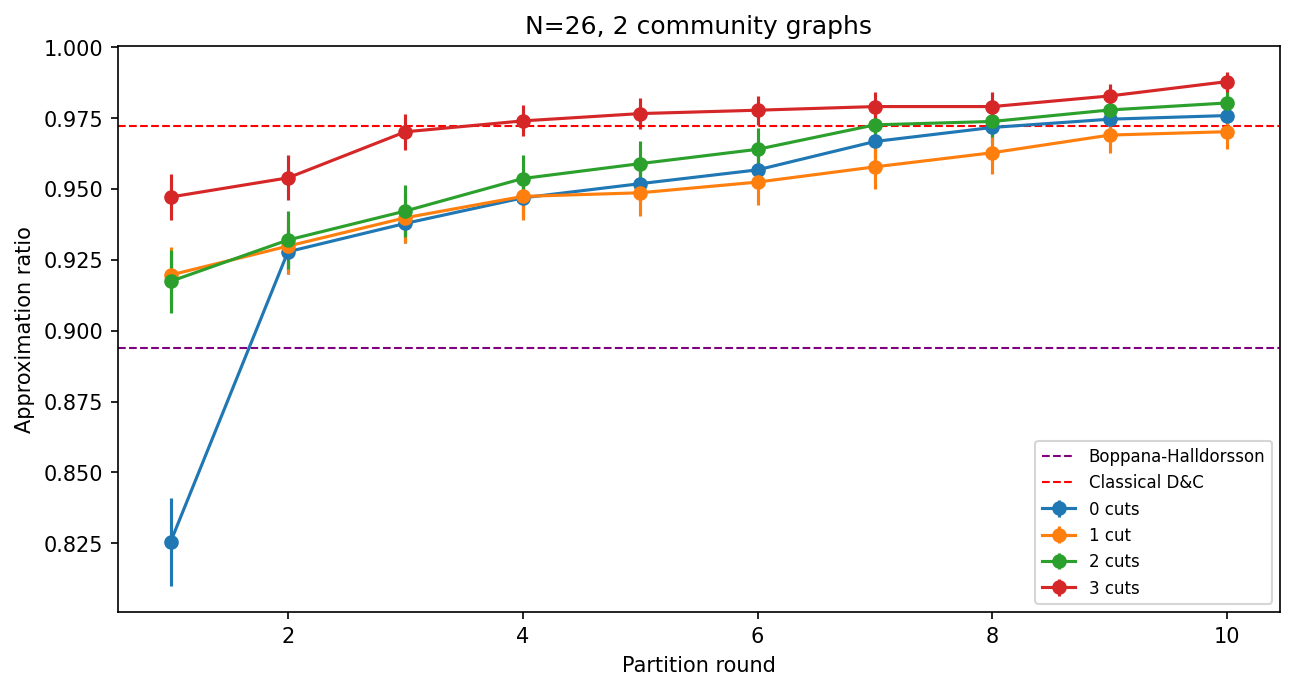

In [145]:
title = 'N=26, 2 community graphs'
plot_approximation_ratios(N26_com2_data, title=title, savefig=None)

## 18-node, 2-community

0 cuts
[0.80981481 0.92603956 0.9565867  0.97589226 0.97755892 0.98107744
 0.98107744 0.98274411 0.98592593 0.98962963]
1 cut
[0.93371633 0.94412037 0.95490741 0.96569444 0.975      0.9787037
 0.98240741 0.98777778 0.98777778 0.98777778]
2 cuts
[0.92431818 0.94917929 0.95084596 0.95269781 0.96677189 0.97070707
 0.97574074 0.97740741 0.98111111 0.98814815]
3 cuts
[0.95399411 0.96473485 0.97214226 0.97865741 0.98050926 0.98236111
 0.98587963 0.98962963 0.9912963  0.995     ]


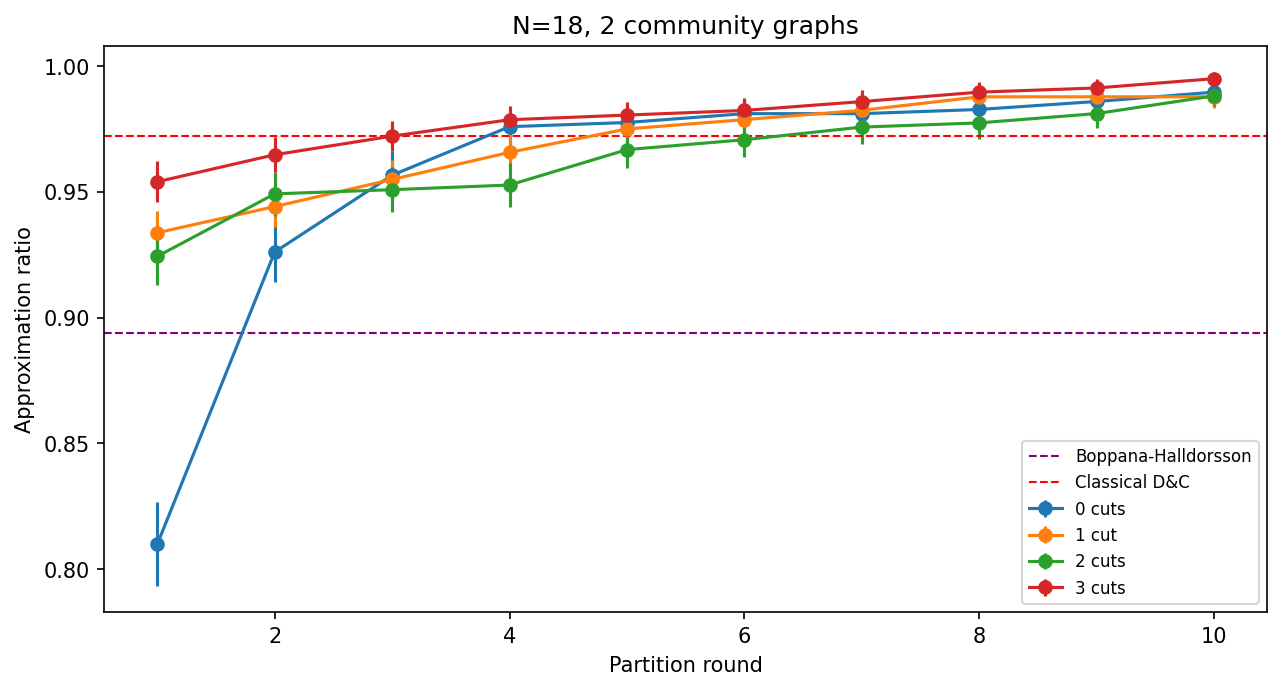

In [146]:
title = 'N=18, 2 community graphs'
plot_approximation_ratios(N18_com2_data, title=title, savefig=None)

## 26-node, 3-regular

0 cuts
[0.58168044 0.76432507 0.82933884 0.8600551  0.88760331 0.90716253
 0.91694215 0.92176309 0.92341598 0.92506887]
1 cut
[0.77245179 0.79352617 0.81460055 0.82933884 0.84090909 0.85730028
 0.86225895 0.88030303 0.88347107 0.88650138]
2 cuts
[0.79655647 0.82603306 0.84407713 0.86033058 0.87823691 0.89297521
 0.89944904 0.91432507 0.91914601 0.9238292 ]
3 cuts
[0.82245179 0.86294766 0.88236915 0.90027548 0.91336088 0.91831956
 0.92644628 0.92809917 0.93636364 0.94283747]


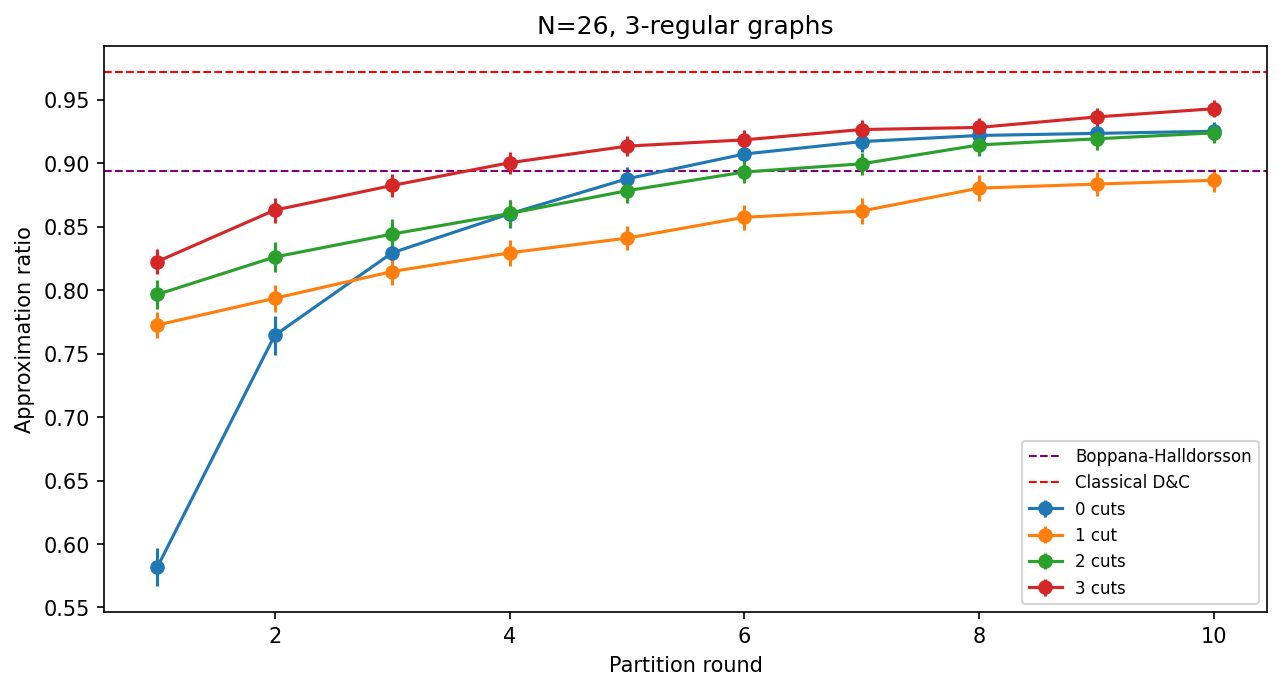

In [147]:
title = 'N=26, 3-regular graphs'
plot_approximation_ratios(N26_d3_data, title=title, savefig=None)

## 18-node, 3-regular

0 cuts
[0.59917027 0.74159452 0.82290765 0.85180375 0.88434343 0.91818182
 0.93701299 0.94220779 0.94707792 0.94707792]
1 cut
[0.77290765 0.79888167 0.823557   0.83297258 0.83524531 0.84953102
 0.85894661 0.86868687 0.88264791 0.89466089]
2 cuts
[0.7965368  0.83225108 0.85822511 0.87608225 0.9017316  0.91147186
 0.91601732 0.92810245 0.93069986 0.94044012]
3 cuts
[0.84108947 0.87193362 0.89888167 0.91608947 0.9209596  0.92979798
 0.93434343 0.94408369 0.96096681 0.96096681]


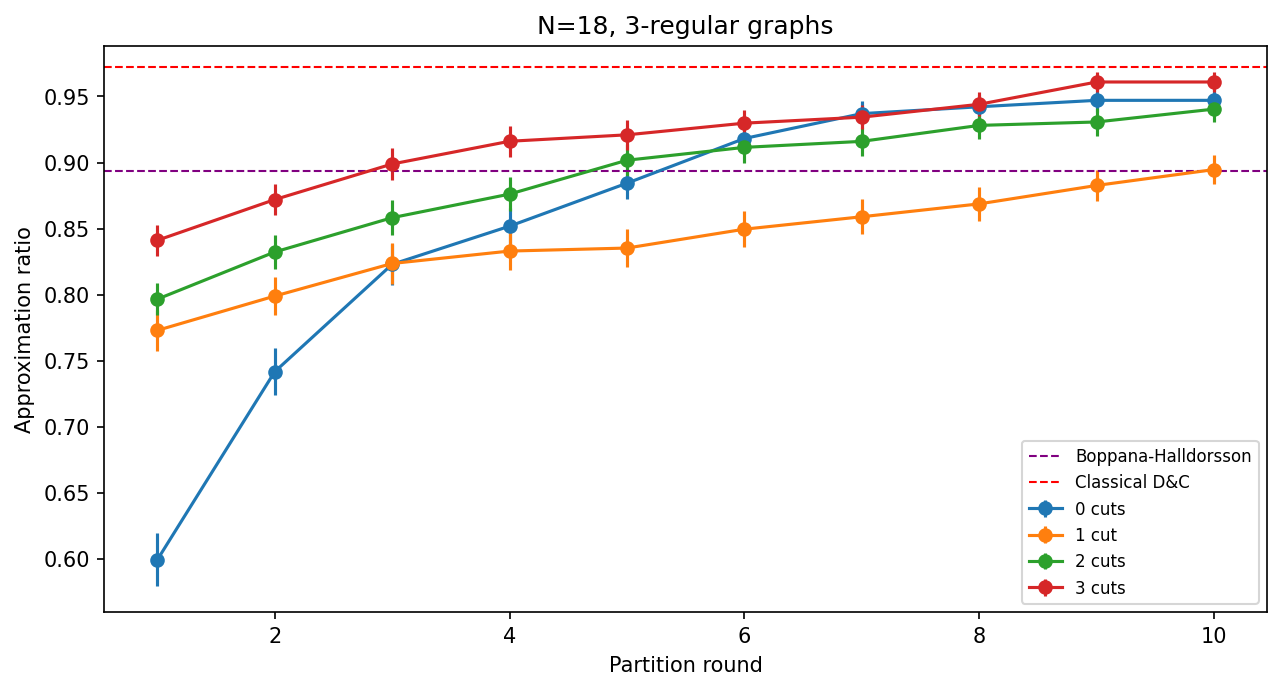

In [148]:
title = 'N=18, 3-regular graphs'
plot_approximation_ratios(N18_d3_data, title=title, savefig=None)

# Shots per fragment

In [44]:
def plot_shots_per_fragment(data, title=None, savefig=None):
    fig, ax = plt.subplots(dpi=250, figsize=[6,2])

    avg_frag_shots = []
    for benchmark, dat in data:
        print(benchmark)
        
        frag_shots = []
        for (graph, sim_result), benchmark_graph in dat:
            temp_frag_shots = []
            for i, partition_round in enumerate(sim_result):
                mixer_round_frag_shots = [history['frag_shots'] for history in partition_round[6][0]]
                temp_frag_shots.append(np.mean(mixer_round_frag_shots))

            frag_shots.append(np.mean(mixer_round_frag_shots))

        avg_frag_shots.append((benchmark.split('frags')[-1].strip('_/'), np.mean(frag_shots), np.std(frag_shots) / np.sqrt(len(frag_shots))))

    xvals = np.arange(len(avg_frag_shots))
    label = [t[0] for t in avg_frag_shots]
    means = [t[1] for t in avg_frag_shots]
    stder = [t[2] for t in avg_frag_shots]
    ax.bar(xvals, means, yerr=stder, tick_label=label, capsize=2)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    
    if title:
        ax.set_title(title)
    ax.set_ylabel('Average shots per fragment')
    
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()
    plt.close()

N18_d3_2frags_0cuts_5000shots/
N18_d3_2frags_1cuts_40000shots/
N18_d3_2frags_2cuts_60000shots/
N18_d3_2frags_3cuts_90000shots/


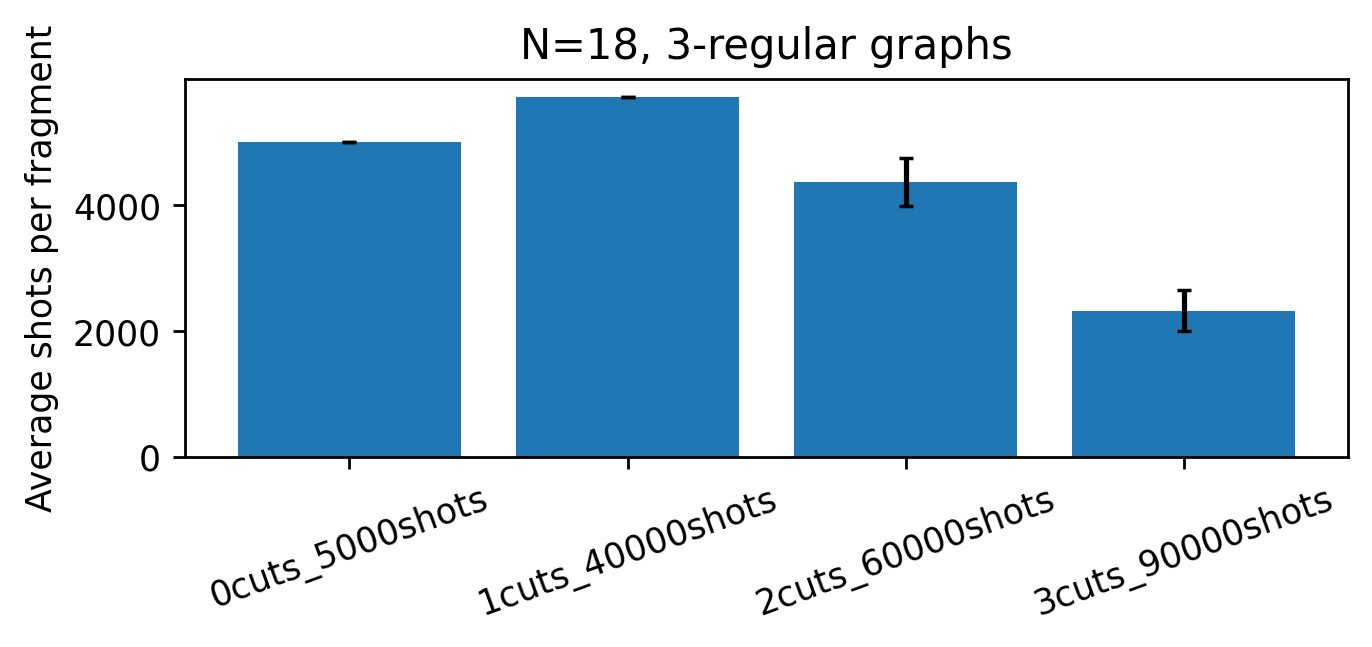

In [45]:
title = 'N=18, 3-regular graphs'
plot_shots_per_fragment(N18_d3_data, title=title, savefig=None)

N26_d3_2frags_0cuts_5000shots/
N26_d3_2frags_1cuts_40000shots/
N26_d3_2frags_2cuts_60000shots/
N26_d3_2frags_3cuts_90000shots/


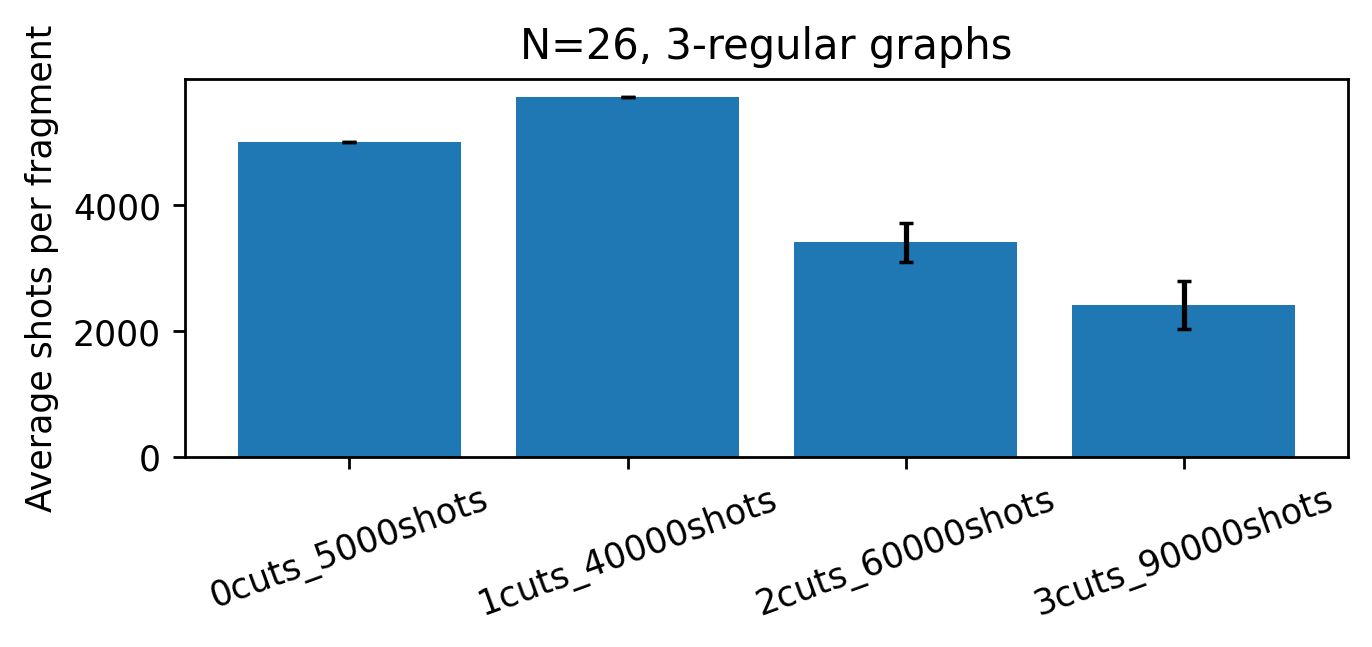

In [61]:
title = 'N=26, 3-regular graphs'
plot_shots_per_fragment(N26_d3_data, title=title, savefig=None)

N18_com2_pin20_pout2_2frags_0cuts_5000shots/
N18_com2_pin20_pout2_2frags_1cuts_40000shots/
N18_com2_pin20_pout2_2frags_2cuts_60000shots/
N18_com2_pin20_pout2_2frags_3cuts_90000shots/


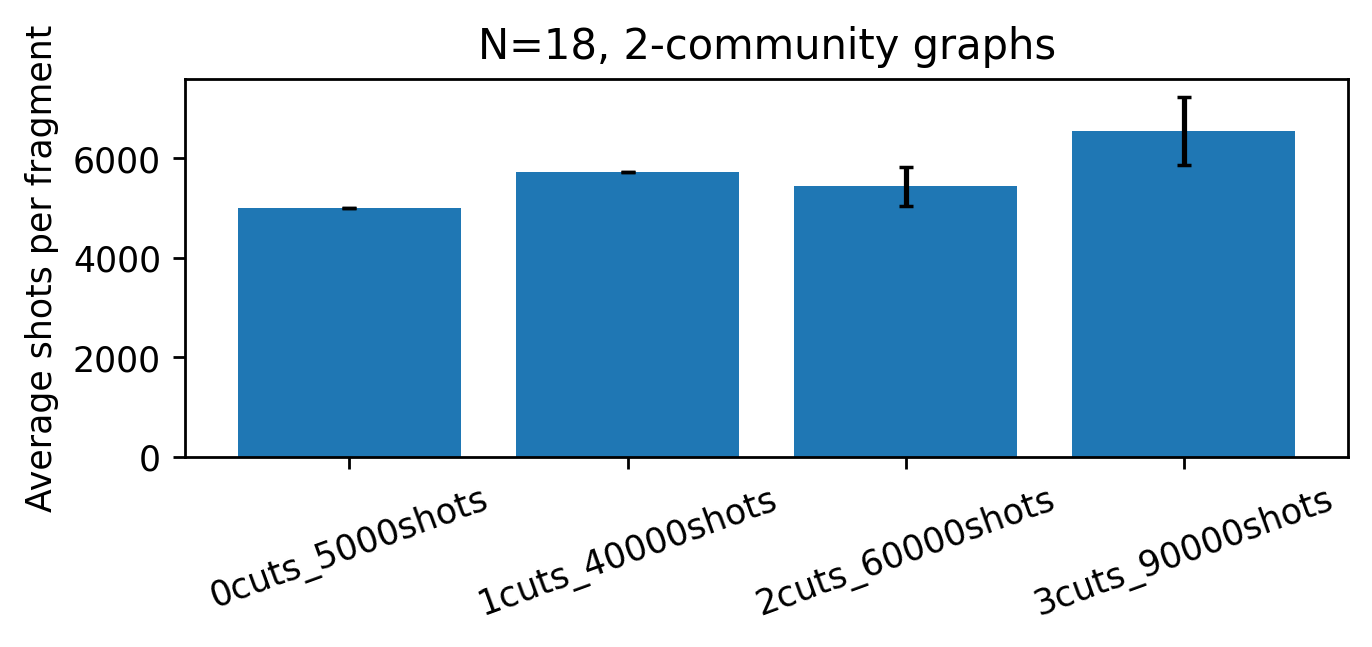

In [62]:
title = 'N=18, 2-community graphs'
plot_shots_per_fragment(N18_com2_data, title=title, savefig=None)

N26_com2_pin20_pout2_2frags_0cuts_5000shots/
N26_com2_pin20_pout2_2frags_1cuts_40000shots/
N26_com2_pin20_pout2_2frags_2cuts_60000shots/
N26_com2_pin20_pout2_2frags_3cuts_90000shots/


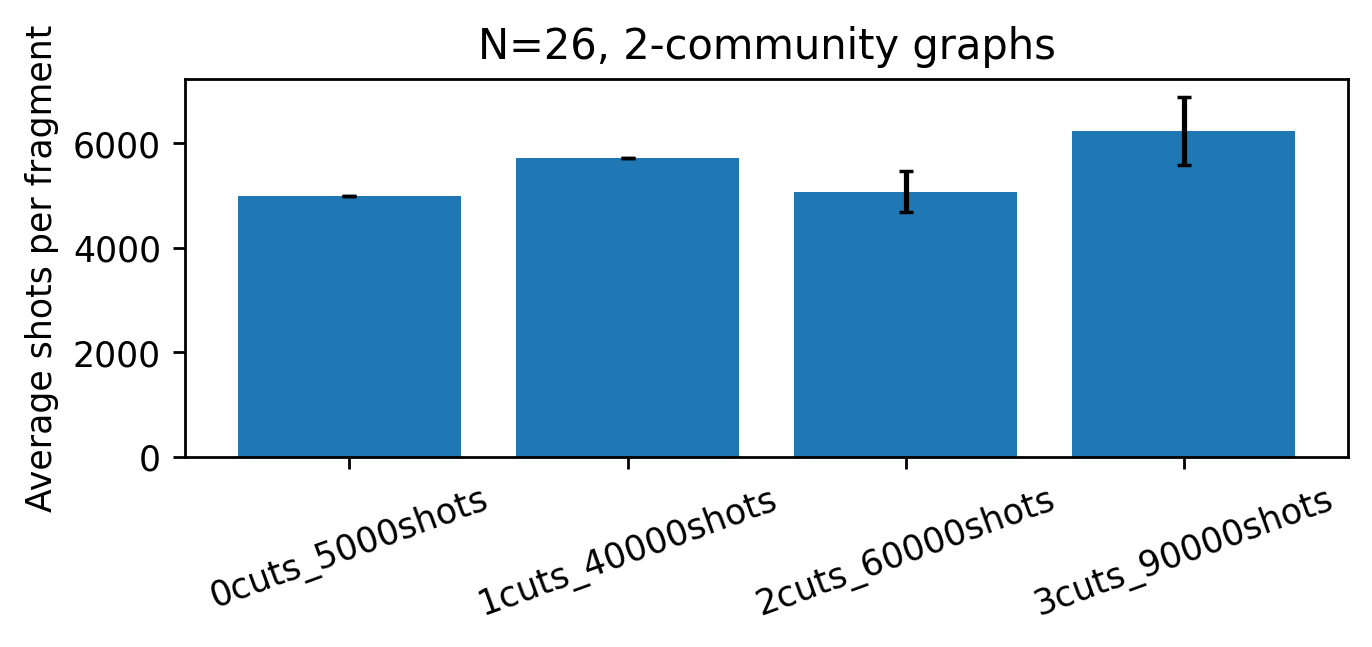

In [63]:
title = 'N=26, 2-community graphs'
plot_shots_per_fragment(N26_com2_data, title=title, savefig=None)

# Number of cut qubits

In [126]:
def plot_average_cut_qubits(data, savefig=None):
    fig, ax = plt.subplots(dpi=250, figsize=[6,2])

    for idx, (benchmark, dat) in enumerate(data):
        print(benchmark)
        total_benchmark_cuts = []
        for (graph, sim_result), benchmark_graph in dat:
            temp_frag_shots = []
            for i, partition_round in enumerate(sim_result):
                found_cuts = [len(history['cuts']) for history in partition_round[6][0]]
                total_benchmark_cuts.extend(found_cuts)

        # Compute the proportions and plot the bars
        total = len(total_benchmark_cuts)
        num_1, num_2, num_3 = 0, 0, 0
        for numcuts in total_benchmark_cuts:
            if numcuts == 1:
                num_1 += 1
            elif numcuts == 2:
                num_2 += 1
            elif numcuts == 3:
                num_3 += 1
        
        if num_1 + num_2 + num_3 != total:
            raise Exception(f'Something isn\'t adding up! {num_1} + {num_2} + {num_3} != {total}')
            
        width = 0.1
        xvals = [x + width * idx for x in range(3)]
        print(xvals)
        label = f"{benchmark.split('_')[1]}, {benchmark.split('_')[-2]}"
        ax.bar(xvals, [val / total for val in [num_1, num_2, num_3]], label=label, width=width, align='edge')
            
    ax.set_xticks([x + 2 * width for x in range(3)])
    ax.set_xticklabels([1,2,3])
    ax.set_ylabel('Proportion of circuits')
    ax.set_xlabel('Number of cuts')
    ax.legend(loc='upper left', fontsize=6)
    
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()
    plt.close()

N26_d3_2frags_2cuts_60000shots/
[0.0, 1.0, 2.0]
N26_com2_pin20_pout2_2frags_2cuts_60000shots/
[0.1, 1.1, 2.1]
N26_d3_2frags_3cuts_90000shots/
[0.2, 1.2, 2.2]
N26_com2_pin20_pout2_2frags_3cuts_90000shots/
[0.30000000000000004, 1.3, 2.3]


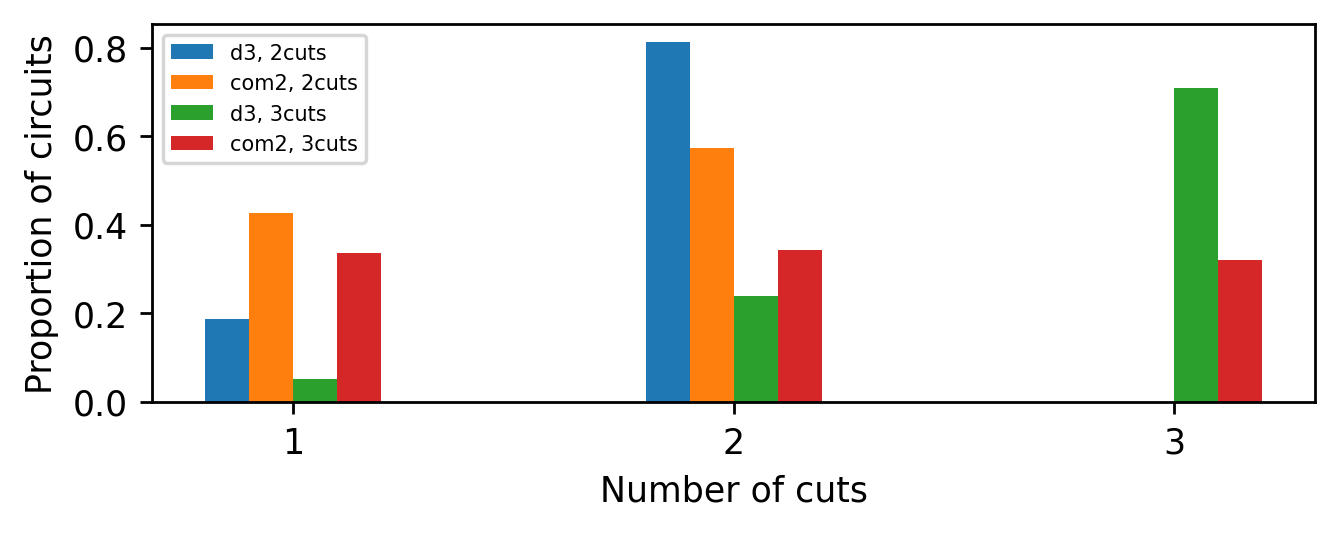

In [127]:
avg_qubit_data = [N26_d3_data[2], N26_com2_data[2], N26_d3_data[3], N26_com2_data[3]]
plot_average_cut_qubits(avg_qubit_data, savefig=None)